In [37]:
import joblib
import pandas as pd
import numpy as np

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt


df = joblib.load("/home/lavrenchuk/TS_Project_Favorita/data/processed/features_agg.joblib")
print(df.shape)
print(df.index.min(), df.index.max())
display(df.tail())

(1687, 23)
2013-01-02 00:00:00 2017-08-15 00:00:00


,unit_sales,unit_sales_log,month,day_of_month,weekday,is_workday,lag_log_1,lag_log_7,lag_log_14,lag_log_28,...,roll_mean_56,roll_std_7,roll_std_28,dow_sin,dow_cos,year_sin,year_cos,is_holiday,before_holiday,after_holiday
date,,,,,,,,,,,,,,,,,,,,,
2017-08-11,80783.227,11.299537,8,11,4,1,10.984767,11.172635,11.192696,11.086023,...,11.230961,0.204764,0.185977,-0.433884,-0.900969,-0.866025,-0.5,0,0,1
2017-08-12,77928.860,11.263564,8,12,5,0,11.299537,11.399004,11.469589,11.365008,...,11.233187,0.206186,0.183745,-0.974928,-0.222521,-0.866025,-0.5,0,0,0
2017-08-13,92090.859,11.430542,8,13,6,0,11.263564,11.571467,11.615288,11.574843,...,11.229576,0.193813,0.182363,-0.781831,0.623490,-0.866025,-0.5,0,0,0
2017-08-14,69852.929,11.154162,8,14,0,1,11.430542,11.195912,11.342291,11.196703,...,11.230797,0.153342,0.174573,0.000000,1.000000,-0.866025,-0.5,0,1,0
2017-08-15,80080.046,11.290794,8,15,1,1,11.154162,11.110238,11.509225,11.098969,...,11.229696,0.153969,0.175148,0.781831,0.623490,-0.866025,-0.5,1,0,0


## Prophet (without holidays)

00:12:51 - cmdstanpy - INFO - Chain [1] start processing


Test period: 2017-05-18 00:00:00 → 2017-08-15 00:00:00


00:12:51 - cmdstanpy - INFO - Chain [1] done processing



Forecast 90 days (real sales):
           ds     yhat_real  yhat_lower_real  yhat_upper_real
0  2017-05-18  58370.526085     23861.102918    143930.897417
1  2017-05-19  63616.748341     24566.563623    159722.872601
2  2017-05-20  90073.118874     33723.915290    229491.231109
3  2017-05-21  88871.720198     33720.423275    219458.389367
4  2017-05-22  75514.674174     30122.232933    189392.685799
..        ...           ...              ...              ...
85 2017-08-11  69514.970183     27665.141389    173563.623850
86 2017-08-12  99523.372417     38605.751509    255782.238436
87 2017-08-13  99200.714905     41257.203217    242626.321486
88 2017-08-14  85047.845627     32539.511805    228239.092544
89 2017-08-15  80123.348795     31484.032931    203453.153396

[90 rows x 4 columns]


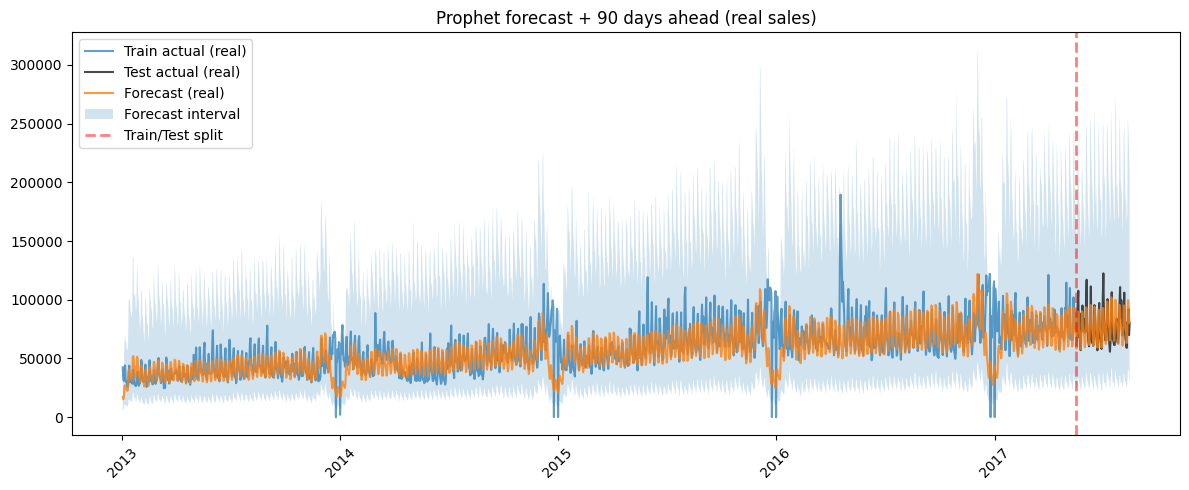

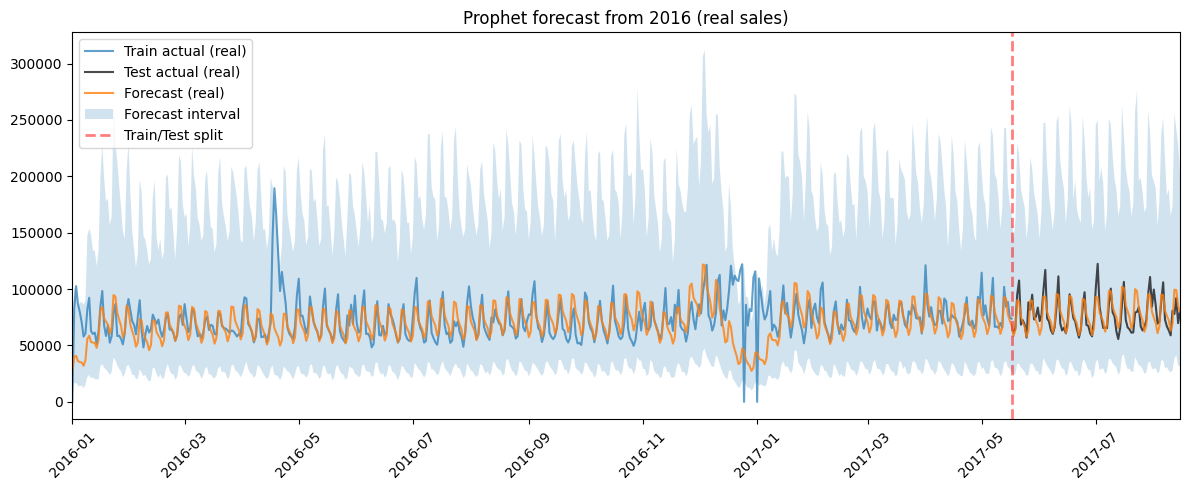

Метрики - прогноз на 90 днів:
MAE_real  = 8055.93
RMSE_real = 10263.01
MAPE_real = 10.17%


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error


df_prophet = df.copy()

df_prophet = df_prophet.reset_index().rename(columns={
    'date': 'ds',          
    'unit_sales_log': 'y'  #будуємо на основі логарифму таргету
})

df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# Спліт на трейн/тест, тест на 90 останніх дніх
train, test = df_prophet[:-90], df_prophet[-90:]
print("Test period:", test['ds'].min(), "→", test['ds'].max())

# Модель Prophet 
model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True
)

model.fit(train)

# Прогноз на 90 днів 
future = model.make_future_dataframe(periods=90, freq='D')
forecast = model.predict(future)

# Беремо тільки 90 майбутніх днів після train
forecast_future = forecast[forecast['ds'] > train['ds'].max()].copy()
forecast_future = forecast_future.sort_values('ds').reset_index(drop=True)

forecast_30 = forecast_future.iloc[:30].copy()
forecast_60 = forecast_future.iloc[:60].copy()
forecast_90 = forecast_future.iloc[:90].copy()

# Перехід з логарифму до натуральних продажів для forecast
forecast['yhat_real'] = np.exp(forecast['yhat'])
forecast['yhat_lower_real'] = np.exp(forecast['yhat_lower'])
forecast['yhat_upper_real'] = np.exp(forecast['yhat_upper'])

for f in [forecast_30, forecast_60, forecast_90]:
    f['yhat_real'] = np.exp(f['yhat'])
    f['yhat_lower_real'] = np.exp(f['yhat_lower'])
    f['yhat_upper_real'] = np.exp(f['yhat_upper'])

# Таблиці прогнозів у натуральних одиницях
#print("\nForecast 30 days (real sales):")
#print(forecast_30[['ds', 'yhat_real', 'yhat_lower_real', 'yhat_upper_real']])

#print("\nForecast 60 days (real sales):")
#print(forecast_60[['ds', 'yhat_real', 'yhat_lower_real', 'yhat_upper_real']])

print("\nForecast 90 days (real sales):")
print(forecast_90[['ds', 'yhat_real', 'yhat_lower_real', 'yhat_upper_real']])

# фактичні продажі у натуральних одиницях
train_real = train.copy()
test_real = test.copy()
train_real['y_real'] = np.exp(train_real['y'])
test_real['y_real'] = np.exp(test_real['y'])

# Графік прогнозу на весь період в натуральних одиницях
plt.figure(figsize=(12, 5))

# історичні значення
plt.plot(train_real['ds'], train_real['y_real'],
         label='Train actual (real)', alpha=0.7)
plt.plot(test_real['ds'], test_real['y_real'],
         label='Test actual (real)', alpha=0.7, color='black')

# прогнозні значення
plt.plot(forecast['ds'], forecast['yhat_real'],
         label='Forecast (real)', alpha=0.8)

# довірчий інтервал
plt.fill_between(
    forecast['ds'],
    forecast['yhat_lower_real'],
    forecast['yhat_upper_real'],
    alpha=0.2,
    label='Forecast interval'
)

# межа між вибірками трейн і тест
plt.axvline(
    x=train['ds'].max(),
    c='red', lw=2, alpha=.5, ls='--',
    label='Train/Test split'
)

plt.title('Prophet forecast + 90 days ahead (real sales)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


#Укрупнений графік тільки з 2016 року
plt.figure(figsize=(12, 5))

mask_2016 = forecast['ds'] >= pd.Timestamp("2016-01-01")

plt.plot(train_real[train_real['ds'] >= pd.Timestamp("2016-01-01")]['ds'],
         train_real[train_real['ds'] >= pd.Timestamp("2016-01-01")]['y_real'],
         label='Train actual (real)', alpha=0.7)

plt.plot(test_real[test_real['ds'] >= pd.Timestamp("2016-01-01")]['ds'],
         test_real[test_real['ds'] >= pd.Timestamp("2016-01-01")]['y_real'],
         label='Test actual (real)', alpha=0.7, color='black')

plt.plot(forecast[mask_2016]['ds'],
         forecast[mask_2016]['yhat_real'],
         label='Forecast (real)', alpha=0.8)

plt.fill_between(
    forecast[mask_2016]['ds'],
    forecast[mask_2016]['yhat_lower_real'],
    forecast[mask_2016]['yhat_upper_real'],
    alpha=0.2,
    label='Forecast interval'
)

plt.axvline(
    x=train['ds'].max(),
    c='red', lw=2, alpha=.5, ls='--',
    label='Train/Test split'
)

plt.xlim(pd.Timestamp("2016-01-01"), forecast['ds'].max())
plt.title('Prophet forecast from 2016 (real sales)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#Метрики в натуральному масштабі (на 90-денному тесті)

# привʼязуємо прогноз до тестових дат
forecast_test = forecast[forecast['ds'].isin(test['ds'])].copy()

df_eval = test[['ds', 'y']].merge(
    forecast_test[['ds', 'yhat']],
    on='ds',
    how='left'
)

# переходимо до натуральних одиниць
df_eval['y_real'] = np.exp(df_eval['y'])
df_eval['yhat_real'] = np.exp(df_eval['yhat'])

MAE_real = mean_absolute_error(df_eval['y_real'], df_eval['yhat_real'])
RMSE_real = np.sqrt(mean_squared_error(df_eval['y_real'], df_eval['yhat_real']))
MAPE_real = np.mean(np.abs((df_eval['y_real'] - df_eval['yhat_real']) / df_eval['y_real'])) * 100

print("Метрики - прогноз на 90 днів:")
print(f"MAE_real  = {MAE_real:.2f}")
print(f"RMSE_real = {RMSE_real:.2f}")
print(f"MAPE_real = {MAPE_real:.2f}%")